## Аналитика в Яндекс.Афише

### Описание проекта

На основе данных от Яндекс.Афиши (с июня 2017 по конец мая 2018 года) необходимо сформировать предложения по оптимизации маркетинговых затрат.

В нашем распоряжении:
* лог сервера с данными о посещениях сайта Яндекс.Афиши
* выгрузка всех заказов за этот период
* статистика рекламных расходов

### Цель исследования:
1. Провести исследовательский анализ данных 
2. Построить отчеты и посчитать метрики для следующих параметров: 
    1. __Продукт__
        * *Сколько людей пользуются продуктом в день, неделю, месяц*
        * *Сколько сессий в день*
        * *Сколько длится одна сессия*
        * *Как часто люди возвращаются*
    2. __Продажи__
        * *Когда люди начинают покупать продукт*
        * *Сколько раз покупают за период*
        * *Какой средний чек*
        * *Сколько денег приносят? (LTV)*
    3. __Маркетинг__
        * *Сколько денег потратили: __Всего__ / __на каждый источник__ / __по времени__*
        * *Сколько стоило привлечение одного покупателя из каждого источника?*
        * *На сколько окупились расходы? (ROI)*
3. Сформулировать вывод на основании проведенного анализа и дать рекомендации для отдела маркетологов

### Информация о входных данных


Таблица __visits__ - лог сервера с информацией о посещениях сайта:
* __``Uid``__ — *уникальный идентификатор пользователя*
* __``Device``__ — *категория устройства пользователя*
* __``Start Ts``__ — *дата и время начала сессии*
* __``End Ts``__ — *дата и время окончания сессии*
* __``Source Id``__ — *идентификатор рекламного источника, из которого пришел пользователь*


Таблица __orders__ - информация о заказах:
* __``Uid``__ — *уникальный id пользователя, который сделал заказ*
* __``Buy Ts``__ — *дата и время заказа*
* __``Revenue``__ — *выручка Яндекс.Афиши с этого заказа*


Таблица __costs__ - информация о затратах на маркетинг:
* __``source_id``__ — *идентификатор рекламного источника*
* __``dt``__ — *дата*
* __``costs``__ — *затраты на этот рекламный источник в этот день*

### Загрузим данные и подготовим их к анализу

#### Загрузка библиотек

In [41]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns; sns.set()
from IPython.display import display
from scipy import stats as st
%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.options.mode.chained_assignment = None

#### Загрузка данных

In [43]:
visits = pd.read_csv('visits_log.csv')  
orders = pd.read_csv('orders_log.csv')  
marketing = pd.read_csv('costs.csv')

In [44]:
# Создаю функцию для получения основной информации о датафрейме
def datainfo(dataframe):
    display(dataframe.head(10))
    display(dataframe.describe())
    dataframe.info()
    print("", sep = '\n\n')
    print("Name of columns:")
    display(dataframe.columns)
    print("", sep = '\n\n')
    print("Unique values:")
    display(dataframe.nunique())
    print("", sep = '\n\n')
    print("Sum of NaN values:")
    display(dataframe.isna().sum())

### EDA

In [45]:
datainfo(visits)

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063


,Source Id,Uid
count,359400.000000,3.594000e+05
mean,3.750515,9.202557e+18
std,1.917116,5.298433e+18
min,1.000000,1.186350e+13
25%,3.000000,4.613407e+18
50%,4.000000,9.227413e+18
75%,5.000000,1.372824e+19
max,10.000000,1.844668e+19


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB

Name of columns:


Index(['Device', 'End Ts', 'Source Id', 'Start Ts', 'Uid'], dtype='object')


Unique values:


Device            2
End Ts       224760
Source Id         9
Start Ts     224303
Uid          228169
dtype: int64


Sum of NaN values:


Device       0
End Ts       0
Source Id    0
Start Ts     0
Uid          0
dtype: int64

In [46]:
datainfo(orders)

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
5,2017-06-01 08:43:00,0.18,10402394430196413321
6,2017-06-01 08:54:00,1.83,12464626743129688638
7,2017-06-01 09:22:00,1.22,3644482766749211722
8,2017-06-01 09:22:00,3.30,17542070709969841479
9,2017-06-01 09:23:00,0.37,1074355127080856382


,Revenue,Uid
count,50415.000000,5.041500e+04
mean,4.999647,9.098161e+18
std,21.818359,5.285742e+18
min,0.000000,3.135781e+14
25%,1.220000,4.533567e+18
50%,2.500000,9.102274e+18
75%,4.890000,1.368290e+19
max,2633.280000,1.844617e+19


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB

Name of columns:


Index(['Buy Ts', 'Revenue', 'Uid'], dtype='object')


Unique values:


Buy Ts     45991
Revenue     1149
Uid        36523
dtype: int64


Sum of NaN values:


Buy Ts     0
Revenue    0
Uid        0
dtype: int64

In [47]:
datainfo(marketing)

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
5,1,2017-06-06,40.39
6,1,2017-06-07,40.59
7,1,2017-06-08,56.63
8,1,2017-06-09,40.16
9,1,2017-06-10,43.24


,source_id,costs
count,2542.000000,2542.000000
mean,4.857199,129.477427
std,3.181581,156.296628
min,1.000000,0.540000
25%,2.000000,21.945000
50%,4.000000,77.295000
75%,9.000000,170.065000
max,10.000000,1788.280000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB

Name of columns:


Index(['source_id', 'dt', 'costs'], dtype='object')


Unique values:


source_id       7
dt            364
costs        2396
dtype: int64


Sum of NaN values:


source_id    0
dt           0
costs        0
dtype: int64

Во всех таблицах проблема некорректного типа данных дат (object вместо datetime64)

In [48]:
# Функцию для изменения типа данных на 'datetime64'
def convert_to_time(dataframe, column, formtype):
    if formtype == 1:    # Если формат даты (год-месяц-день час:минута:секунда)
        result = pd.to_datetime(dataframe[column], format='%Y-%m-%d %H:%M:%S')
        return result
    elif formtype == 2:  # Если формат даты (год-месяц-день)
        result = pd.to_datetime(dataframe[column], format='%Y-%m-%d')
        return result
    else:
        print('Некорректный формат даты')

In [49]:
#Изменяем типы данных и проверяем
visits['End Ts'] = convert_to_time(visits, 'End Ts', 1) 
visits['Start Ts'] = convert_to_time(visits, 'Start Ts', 1)
orders['Buy Ts'] = convert_to_time(orders, 'Buy Ts', 1)
marketing['dt'] = convert_to_time(marketing, 'dt', 2)
print(visits['End Ts'].dtype)  
print(visits['Start Ts'].dtype) 
print(orders['Buy Ts'].dtype)
print(marketing['dt'].dtype)

datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]


In [50]:
#напишем функцию перевода столбцов к нижнему регистру и замены пробелов на "_" 
def replace_columns_names(data):
    list_of_columns = []
    for column in data.columns:
        column = column.lower()
        column = column.replace(' ', '_')
        list_of_columns.append(column)
    data.columns = list_of_columns
    return data

In [51]:
visits = replace_columns_names(visits)
orders = replace_columns_names(orders)
marketing = replace_columns_names(marketing)

В таблице orders есть значения с revenue = 0, исследуем этот вопрос

In [53]:
print('Количество строк с нулевым значением:', orders[orders['revenue'] == 0]['revenue'].count())
print('Доля нулевых значений от общего количества записей: {:.2%}'.format(orders[orders['revenue'] == 0]['revenue'].count() / len(orders)))

Количество строк с нулевым значением: 51
Доля нулевых значений от общего количества записей: 0.10%


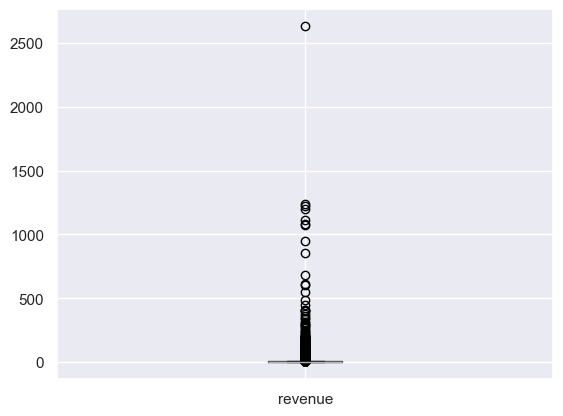

In [54]:
orders.boxplot(column='revenue')
plt.show()

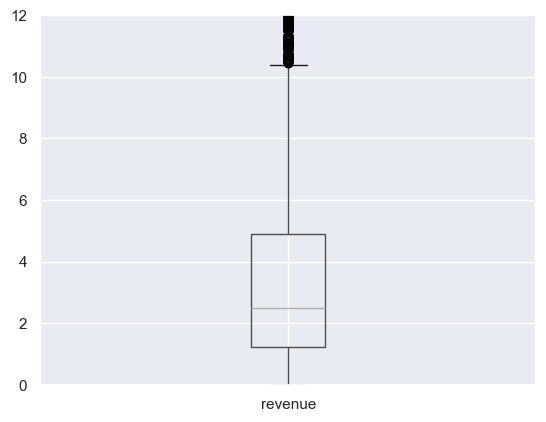

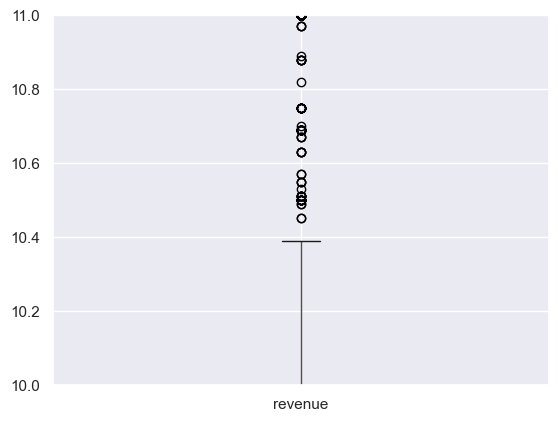

In [55]:
plt.ylim(0, 12)
orders.boxplot(column='revenue', figsize=(10,5))
plt.figure()
plt.ylim(10, 11)
orders.boxplot(column='revenue', figsize=(10,5)) # revenue < 10.5
plt.show()

In [56]:
#видим что выбросы начинаются со значения 10.4
print(len(orders[orders['revenue'] >= 10.4]))
print('Доля выбросов:', round((len(orders[orders['revenue'] >= 10.4]) / len(orders) * 100)), '%')

3990
Доля выбросов: 8 %


### Расчет метрик и построение отчётов

#### Продукт

***Количество пользователе продуктом в день(DAU), неделю(WAU), месяц(MAU)***

* __DAU__ *(от англ. daily active users)* — количество уникальных пользователей в день
* __WAU__ *(от англ. weekly active users)* — количество уникальных пользователей в неделю
* __MAU__ *(от англ. monthly active users)* — количество уникальных пользователей в месяц

In [57]:
#разобъем дату на столбцы: год, месяц, неделя, день
visits['day'] = visits['start_ts'].dt.day
visits['week'] = visits['start_ts'].dt.isocalendar().week
visits['month'] = visits['start_ts'].dt.month
visits['year'] = visits['start_ts'].dt.year
visits['date'] = visits['start_ts'].dt.date

visits.sample(5)

,device,end_ts,source_id,start_ts,uid,day,week,month,year,date
334833,desktop,2017-11-08 16:11:00,5,2017-11-08 16:11:00,4096603975948930813,8,45,11,2017,2017-11-08
296615,touch,2017-12-03 16:19:00,1,2017-12-03 15:23:00,2104462645320428573,3,48,12,2017,2017-12-03
217282,desktop,2017-12-20 12:18:00,4,2017-12-20 12:16:00,14717087967047848715,20,51,12,2017,2017-12-20
54162,touch,2017-09-10 12:02:00,5,2017-09-10 11:53:00,15069707354821787560,10,36,9,2017,2017-09-10
145552,desktop,2017-12-10 12:29:00,1,2017-12-10 12:27:00,10745555005165856232,10,49,12,2017,2017-12-10


In [62]:
"""
Функция подсчитывает количество уникальных пользователей и количество сессий за период, выводит графики;
строит графики распределений, а также выводит описание .describe() группировки.
Входные параметры:
    `df` - датафрейм с информацией о посещениях сервиса
    `period` - список полей для группировки по периоду
    `period_name` - название периода в винительном падеже для заголовков.
"""
def nusers_period(df, period, period_name):  
    nusers = (df.groupby(period)
                  .agg(
                      user_count = ('uid','nunique'),
                      session_count = ('uid','count'))
             )
    nusers['sessions_per_user'] = nusers['session_count'] /  nusers['user_count']
    display(nusers.sample(5))
    nusers.sort_values(by=period, inplace=True)
    nusers[['user_count', 'session_count']].plot(figsize=(15,5), grid=True, style='o', title='Количество пользователей/сессий в '+ period_name)
    plt.ylabel('количество пользователей/сессий')
    plt.show()
    
    plt.figure(figsize=(10,5))
    sns.distplot(nusers['user_count'], bins=20, label='пользователи')
    sns.distplot(nusers['session_count'], bins=20, label='сессии')
    plt.title('Распределение количества пользователей/сессий в ' + period_name)
    plt.legend()
    plt.show() 
    
    display(nusers.describe())

,user_count,session_count,sessions_per_user
date,,,
2017-09-29,1074,1167,1.086592
2017-06-18,285,306,1.073684
2017-09-30,847,890,1.050767
2018-01-20,980,1061,1.082653
2017-08-06,282,296,1.049645


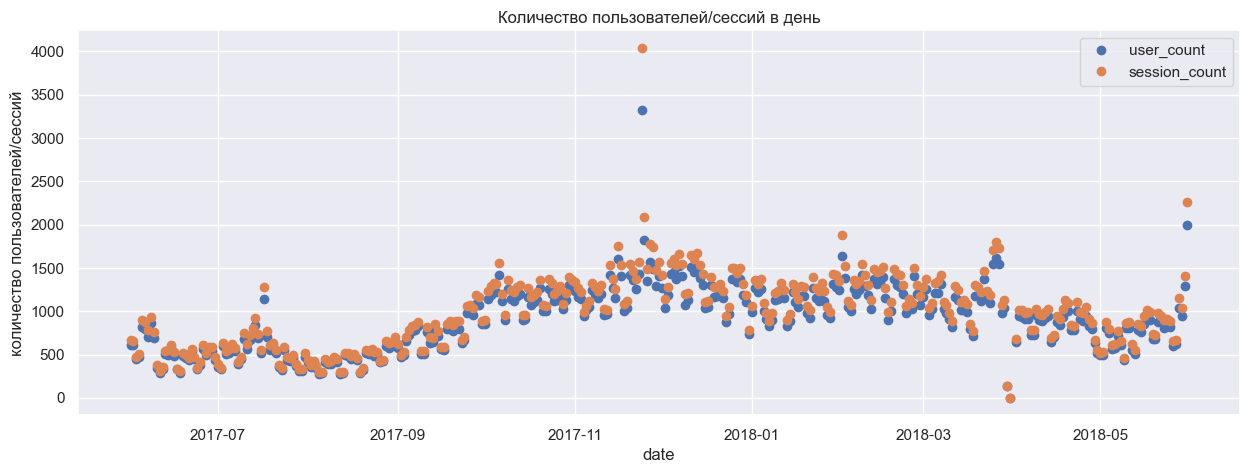

C:\Users\Екатерина\AppData\Local\Temp\ipykernel_15216\2271751471.py:23: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(nusers['user_count'], bins=20, label='пользователи')
C:\Users\Екатерина\AppData\Local\Temp\ipykernel_15216\2271751471.py:24: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(nusers[

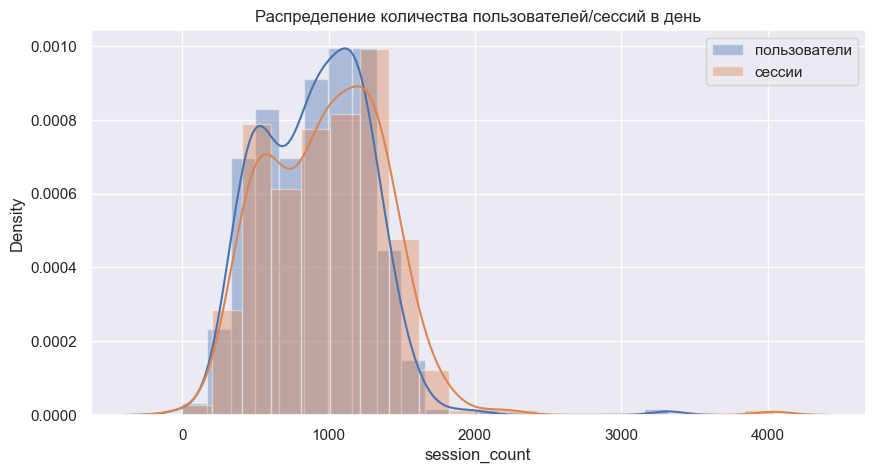

,user_count,session_count,sessions_per_user
count,364.000000,364.000000,364.000000
mean,907.991758,987.362637,1.082170
std,370.513838,418.994796,0.020876
min,1.000000,1.000000,1.000000
25%,594.000000,635.500000,1.070321
50%,921.000000,1003.000000,1.082488
75%,1173.000000,1280.000000,1.093876
max,3319.000000,4042.000000,1.217837


In [63]:
# Посмотрим, сколько людей пользуются сервисом в день:
nusers_period(visits, ['date'], 'день')

***Количество сессий в день()и***

***Длительность одной сессии***

***Как часто люди возвращаются***

#### Продажи

***Когда люди начинают покупать продукт***

***Сколько раз покупают за период***

***Средний чек***

***Сколько денег приносят?(LTV)***

#### Маркетинг

***Сколько денег потратили всего/на один источник/по времени***

***Сколько стоит привлечение одного покупателя из каждого источника?***

***На сколько окупились расходы?(ROI)***

Когортный анализ (Cohort analysis) — метод оценки каких-либо метрик с разделением пользователей на независимые группы — когорты.
Life-Time Value (LTV) — характеристика группы клиентов, которая показывает, сколько дохода в среднем приносит клиент из этой группы.

Самые распространенные ошибки при расчете LTV:

Расчет LTV на основе выручки (Revenue), а не валовой прибыли (Gross Profit);
Расчет LTV через Lifetime пользователей, полученный через 1/churn или другими способами;
Расчет LTV через среднее количество покупок пользователей.